## Import packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Dense, BatchNormalization
from keras.callbacks import LambdaCallback, ModelCheckpoint

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn.metrics import mean_squared_error

import pickle
from time import time

Using TensorFlow backend.


In [2]:
plt.rcParams['figure.figsize'] = [16, 6]

### Helper function to get and process the data

In [3]:
def dataget(train_path, description_path, test_path):

    train_data = pd.read_csv(train_path, parse_dates=['booking_date', 'checkin_date', 'checkout_date'], infer_datetime_format=True)
    description_data = pd.read_excel(description_path)
    test_data = pd.read_csv(test_path, parse_dates=['booking_date', 'checkin_date', 'checkout_date'], infer_datetime_format=True)
    
    return train_data, description_data, test_data

In [5]:
train_path = 'train.csv'
description_path = 'Data_Dictionary.xlsx'
test_path = 'test.csv'
train_data, description_data, test_data = dataget(train_path, description_path, test_path)
df = train_data.copy()
columns = df.columns
df.head()

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,...,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...,2018-05-04,2018-05-04,2018-06-04,3,1,2,0,46,3,...,7.0,3,3,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,C,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,7.706428
1,03930f033646d073462b35d411616323597715ac4fc398...,2015-01-23,2015-11-04,2015-04-16,1,1,2,0,46,3,...,7.0,5,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,A,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac...,6.662563
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,2015-01-28,2015-01-02,2015-05-02,1,1,2,0,47,1,...,7.0,1,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,E,A,535fa30d7e25dd8a49f1536779734ec8286108d115da50...,7.871602
3,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,2015-02-05,2015-11-06,2015-06-16,1,1,2,2,46,2,...,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,5.344943
4,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,2015-02-09,2015-12-14,2015-12-19,1,1,2,0,46,2,...,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,7.059346


In [7]:
description_data

,Variable,Description
0,reservation_id,Reservation ID
1,booking_date,Date of booking
2,checkin_date,Checkin date recorded at the time of booking
3,checkout_date,Checkout date recorded at the time of booking
4,channel_code,Different channels of booking
5,main_product_code,Type of product a member has purchased
6,numberofadults,Number of adults travelling
7,numberofchildren,Number of children travelling
8,persontravellingid,Type of person travelling
9,resort_region_code,Resort Region


<h3> Preprocess as below</h3>
<ul>
    <li>Drop reservation_id</li>
    <li>Compute abs(diff(booking_date,checkin_date))</li>
    <li>Compute abs(diff(checkin_date, checkout_date))</li>
    <li>Drop booking_date, checkin_date, checkout_date, reservation_id, state_code_residence, persontravellingid, memberid, resort_id</li>
<li>Categories state_code_resort, channel_code, resort_region_code, season_holidayed_code, member_age_buckets, booking_type_code, cluster_code, reservationstatusid_code</li>
    <li>abs(roomnights)</li>
</ul>

In [8]:
print(df.describe())

        channel_code  main_product_code  numberofadults  numberofchildren  \
count  341424.000000      341424.000000   341424.000000     341424.000000   
mean        1.902810           2.208738        3.275361          0.362696   
std         0.915311           0.823779        1.756062          0.758019   
min         1.000000           1.000000        0.000000          0.000000   
25%         1.000000           2.000000        2.000000          0.000000   
50%         2.000000           2.000000        3.000000          0.000000   
75%         3.000000           3.000000        4.000000          0.000000   
max         3.000000           7.000000       32.000000         13.000000   

       persontravellingid  resort_region_code  resort_type_code  \
count       341424.000000       341424.000000     341424.000000   
mean           210.288905            1.772960          2.193832   
std            865.735577            0.750806          1.551451   
min             45.000000            1

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341424 entries, 0 to 341423
Data columns (total 24 columns):
reservation_id                        341424 non-null object
booking_date                          341424 non-null datetime64[ns]
checkin_date                          341424 non-null datetime64[ns]
checkout_date                         341424 non-null datetime64[ns]
channel_code                          341424 non-null int64
main_product_code                     341424 non-null int64
numberofadults                        341424 non-null int64
numberofchildren                      341424 non-null int64
persontravellingid                    341424 non-null int64
resort_region_code                    341424 non-null int64
resort_type_code                      341424 non-null int64
room_type_booked_code                 341424 non-null int64
roomnights                            341424 non-null int64
season_holidayed_code                 341310 non-null float64
state_code_residenc

In [10]:
df['roomnights'] = df['roomnights'].abs()
df['time_to_vacation'] = (df['checkin_date'] - df['booking_date']).dt.days.abs()
df['time_in_vacation'] = (df['checkout_date'] - df['checkin_date']).dt.days.abs()
drop_cols = ['booking_date', 'checkin_date', 'checkout_date', 'reservation_id', 'state_code_residence', 'persontravellingid', 'memberid', 'resort_id']
df.drop(drop_cols, axis=1, inplace=True)
categories = ['state_code_resort', 'channel_code', 'resort_region_code', 'season_holidayed_code', 'member_age_buckets', 'booking_type_code', 'cluster_code', 'reservationstatusid_code']
df[categories] = df[categories].apply(lambda x: x.astype('category'))
plt_data = df.copy()
df = pd.get_dummies(df, drop_first=True)

In [11]:
x_train = df.copy()
y_train = x_train['amount_spent_per_room_night_scaled'].values
x_train.drop(['amount_spent_per_room_night_scaled'], axis=1, inplace=True)

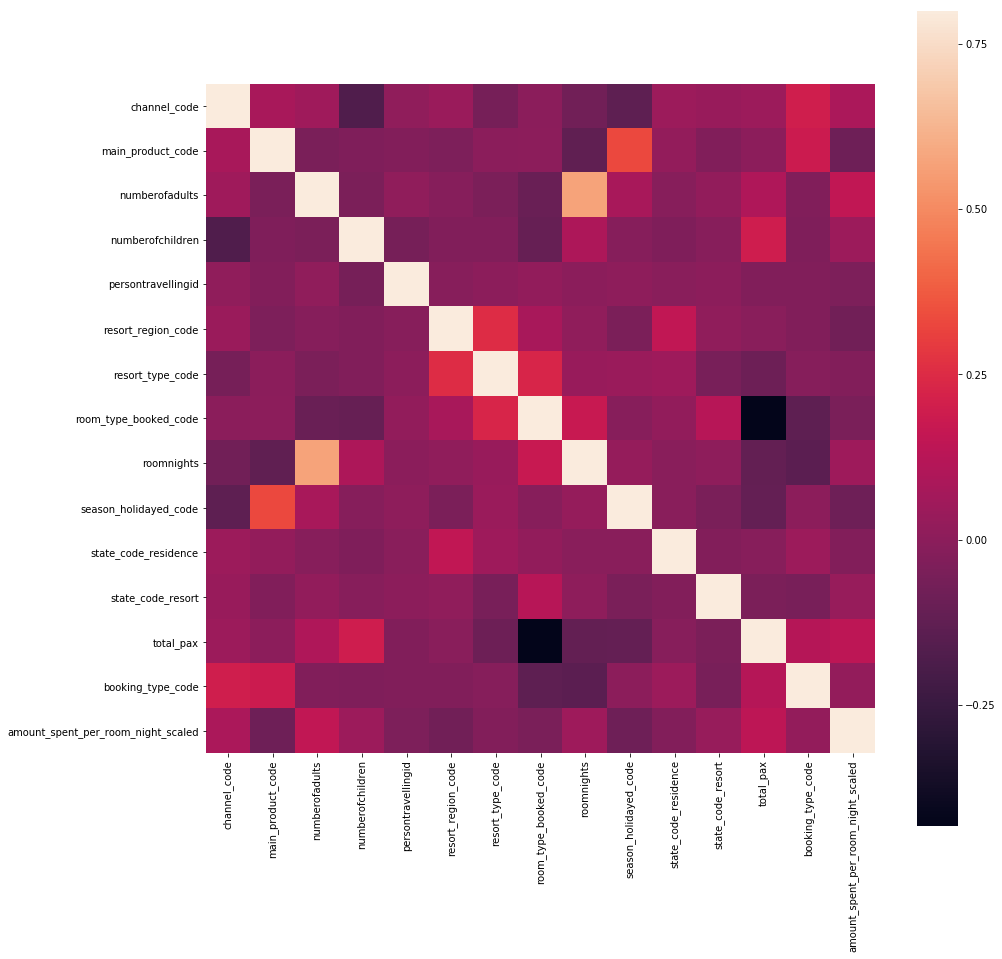

In [12]:
C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sns.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [89]:
epochs = 15
modelh5 = 'ClubMahindraRegressor'
loadmodelh5 = 'ClubMahindraRegressor-best'

In [96]:
try:
    model = load_model(loadmodelh5 + '.h5')
    print('Model loaded successfully')
except IOError:
    print('Building the model for the first time')
    model = Sequential()
    model.add(Dense(44, input_dim=44, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(64, kernel_initializer='normal', activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(64, kernel_initializer='normal', activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(32, kernel_initializer='normal', activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam',  metrics=['mse'])
savebestmodel = ModelCheckpoint(modelh5 + '-best.h5', monitor='loss', verbose=0, save_best_only=True)

Building the model for the first time


In [97]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 44)                1980      
_________________________________________________________________
batch_normalization_31 (Batc (None, 44)                176       
_________________________________________________________________
dense_40 (Dense)             (None, 64)                2880      
_________________________________________________________________
batch_normalization_32 (Batc (None, 64)                256       
_________________________________________________________________
dense_41 (Dense)             (None, 64)                4160      
_________________________________________________________________
batch_normalization_33 (Batc (None, 64)                256       
_________________________________________________________________
dense_42 (Dense)             (None, 32)                2080      
__________

# Scale the data to a single range

In [94]:
scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)

In [103]:
%%time
model.fit(x_train, y_train,
          validation_split=0.01, epochs=epochs, batch_size=1024, callbacks=[savebestmodel])

Train on 338009 samples, validate on 3415 samples
Epoch 1/15
338009/338009 [==============================] - 9s 26us/step - loss: 0.0172 - mean_squared_error: 1.0608 - val_loss: 0.0179 - val_mean_squared_error: 1.1561
Epoch 2/15
338009/338009 [==============================] - 7s 20us/step - loss: 0.0172 - mean_squared_error: 1.0611 - val_loss: 0.0181 - val_mean_squared_error: 1.1722
Epoch 3/15
338009/338009 [==============================] - 9s 27us/step - loss: 0.0172 - mean_squared_error: 1.0611 - val_loss: 0.0178 - val_mean_squared_error: 1.1346
Epoch 4/15
338009/338009 [==============================] - 8s 25us/step - loss: 0.0172 - mean_squared_error: 1.0607 - val_loss: 0.0181 - val_mean_squared_error: 1.1657
Epoch 5/15
338009/338009 [==============================] - 7s 20us/step - loss: 0.0172 - mean_squared_error: 1.0592 - val_loss: 0.0178 - val_mean_squared_error: 1.1404
Epoch 6/15
338009/338009 [==============================] - 7s 20us/step - loss: 0.0172 - mean_squared_er

In [101]:
y_true, y_pred = y_train, model.predict(x_train, batch_size=1024)

In [102]:
print(r2_score(y_true, y_pred))

0.10762892937103319


In [74]:
mean_squared_error(y_true, y_pred)

0.9888111334420759

In [75]:
y_true[0:20]

array([7.70642846, 6.66256293, 7.87160208, 5.34494329, 7.05934611,
       8.16770664, 6.44983831, 7.04617197, 5.39420314, 6.56141249,
       6.82000545, 6.62445028, 7.47622886, 4.13963655, 9.93215324,
       3.21887583, 9.68403954, 7.27534197, 5.17507571, 7.46175676])

In [76]:
y_pred[0:20]

array([[8.098379 ],
       [7.080516 ],
       [7.5877323],
       [7.2183204],
       [6.807995 ],
       [7.510646 ],
       [7.5803256],
       [7.7134852],
       [6.801401 ],
       [7.491496 ],
       [7.4881096],
       [8.154101 ],
       [7.754867 ],
       [7.5848618],
       [8.62653  ],
       [7.2999454],
       [8.259057 ],
       [7.2715187],
       [7.438636 ],
       [8.110057 ]], dtype=float32)

In [77]:
df = test_data.copy()
df['roomnights'] = df['roomnights'].abs()
df['time_to_vacation'] = (df['checkin_date'] - df['booking_date']).dt.days.abs()
df['time_in_vacation'] = (df['checkout_date'] - df['checkin_date']).dt.days.abs()
drop_cols = ['booking_date', 'checkin_date', 'checkout_date', 'reservation_id', 'state_code_residence', 'persontravellingid', 'state_code_residence', 'memberid', 'resort_id']
df.drop(drop_cols, axis=1, inplace=True)
categories = ['state_code_resort', 'channel_code', 'resort_region_code', 'season_holidayed_code', 'member_age_buckets', 'booking_type_code', 'cluster_code', 'reservationstatusid_code']
df[categories] = df[categories].apply(lambda x: x.astype('category'))
plt_data = df.copy()
df = pd.get_dummies(df, drop_first=True)

In [78]:
x_test = df.copy()

In [79]:
x_test['reservationstatusid_code_D'] = 0

In [80]:
x_test = scaler.fit_transform(x_test)

In [81]:
y_pred = model.predict(x_test, batch_size=1024)

In [82]:
ids = test_data['reservation_id'].values

In [83]:
res = pd.DataFrame(data={'reservation_id' : ids})
res['amount_spent_per_room_night_scaled'] = y_pred
res.to_csv('submission.csv', index=False)